<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/caltech101_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import os
import math
import tensorflow as tf

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 102
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (128, 128)
input_shape = (128, 128, 3)
num_classes = 102

In [5]:
import gzip
import pickle

os.chdir(path)

with gzip.open('caltech101_x_trainData_128.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('caltech101_x_testData_128.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('caltech101_y_trainData_128.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with gzip.open('caltech101_y_testData_128.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [6]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
# convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet56v1
x_train shape: (7316, 128, 128, 3)
7316 train samples
1829 test samples
y_train shape: (7316, 102)


In [7]:
model_path = '/content/gdrive/My Drive/caltech101/CALTECH-101_ResNet56v1_model.138.h5'
model = tf.keras.models.load_model(model_path) # load model

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

58/58 [==============================] - 14s 219ms/step - loss: 1.4723 - acc: 0.7835


[1.472270131111145, 0.7834882736206055]

In [10]:
print(y_pred)

[[3.25766856e-24 9.97072101e-01 2.49045278e-13 ... 5.98524962e-12
  1.85077058e-11 4.33529288e-18]
 [7.57454457e-27 1.00000000e+00 6.21929981e-12 ... 1.16649723e-18
  2.75122026e-12 1.05088830e-17]
 [2.57545466e-22 2.91193909e-11 5.16740581e-14 ... 8.28644916e-20
  7.42279328e-21 1.73477530e-20]
 ...
 [5.15116924e-18 3.60312891e-09 3.83576682e-09 ... 3.63942464e-13
  7.32337314e-13 1.06008884e-13]
 [4.54597873e-14 3.35585605e-06 1.40163000e-03 ... 9.68478769e-14
  6.05487321e-06 8.82767272e-05]
 [6.57205130e-19 4.11069139e-12 2.18965579e-09 ... 2.82286885e-16
  8.00940356e-11 3.41913026e-10]]


In [11]:
print(sum(y_pred[50]))

1.000000000144006


In [12]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[2.9320745e-03 1.1920930e-07 1.1920930e-07 ... 3.5271817e-01 4.5536587e-01
 9.2075162e-02]


In [13]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [14]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1433
396


In [15]:
import matplotlib.pyplot as plt

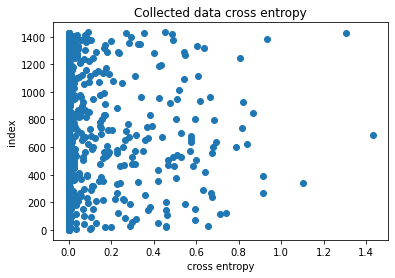

In [16]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

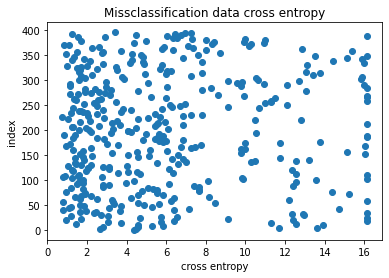

In [17]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

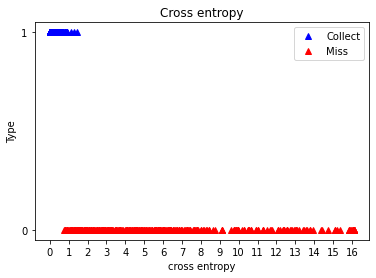

In [18]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [19]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.4324796
0.76600623


In [20]:
cnt = 0

for i in collect_Cce : 
  if i < 0.0001 :
    cnt = cnt + 1
print(cnt)
print(cnt/len(collect_Cce))

852
0.5945568736915562


In [53]:
def static_Threshold() :
  threshold = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  return threshold

In [54]:
staticThreshold = static_Threshold()
print(staticThreshold)

[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [23]:
n_cce = cce/max(cce)

In [24]:
def dynamic_Threshold(cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [2.326, 1.96, 1.645] # 95%, 97.5%, 99% one-tails
  threshold = []
  x_ = np.mean(cce)
  o = np.std(cce)
  n = len(cce) **(1/2)
  print(x_)
  print(o)
  print(n)
  for z in Z :
    threshold.append(x_- (z * o)/n)

  return threshold

In [25]:
dynamicThreshold = dynamic_Threshold(n_cce)
dynamicThreshold.append(min(missclassification_Cce))
print(dynamicThreshold)

0.08211396
0.19660594
42.76680956068619
[0.0714209609578105, 0.07310352211219008, 0.07455162802374629, 0.76600623]


In [26]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [27]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [28]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [33]:
for i in range(len(PMD_By_Static_Threshold)) :
  print(staticThreshold[i], len(PMD_By_Static_Threshold[i]))

for i in range(len(PMD_By_Dynamic_Threshold)) :
  print(dynamicThreshold[i], len(PMD_By_Dynamic_Threshold[i]))

1e-07 1433
1e-06 820
5e-05 617
1e-05 710
0.0001 581
0.0005 483
0.001 455
0.01 313
0.05 217
0.1 170
0.2 120
0.3 88
0.4 69
0.5 48
0.0714209609578105 196
0.07310352211219008 193
0.07455162802374629 191
0.76600623 12


In [34]:
import cv2

In [35]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, (128, 128), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [36]:
def img_trim(img, size) :
  w = 128
  h = 128
  new_img = img[size:size+h, size:size+w]
  return new_img

In [37]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (128, 128), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [38]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [39]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [40]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  print("        PMD : " + str(len(PMD)))
  print("        MD : " + str(len(MD)))
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [41]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [42]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [43]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [44]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [45]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [46]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [47]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.7545106615636961
    Find MD : 106
      static threshold
        1st static threshold
        PMD : 1433
        MD : 106
        Precision : 0.07397069085833916
        Recall : 1.0

        2st static threshold
        PMD : 820
        MD : 106
        Precision : 0.12804878048780488
        Recall : 0.9905660377358491

        3st static threshold
        PMD : 617
        MD : 106
        Precision : 0.16369529983792544
        Recall : 0.9528301886792453

        4st static threshold
        PMD : 710
        MD : 106
        Precision : 0.14647887323943662
        Recall : 0.9811320754716981

        5st static threshold
        PMD : 581
        MD : 106
        Precision : 0.1721170395869191
        Recall : 0.9433962264150944

        6st static threshold
        PMD : 483
        MD : 106
        Precision : 0.20496894409937888
        Recall : 0.9339622641509434

        7st static threshold
        PMD : 455
        MD : 106
        Precision : 0

In [48]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.764898851831602
    Find MD : 87
      static threshold
        1st static threshold
        PMD : 1433
        MD : 87
        Precision : 0.06071179344033496
        Recall : 1.0

        2st static threshold
        PMD : 820
        MD : 87
        Precision : 0.09024390243902439
        Recall : 0.8505747126436781

        3st static threshold
        PMD : 617
        MD : 87
        Precision : 0.10696920583468396
        Recall : 0.7586206896551724

        4st static threshold
        PMD : 710
        MD : 87
        Precision : 0.09577464788732394
        Recall : 0.7816091954022989

        5st static threshold
        PMD : 581
        MD : 87
        Precision : 0.11187607573149742
        Recall : 0.7471264367816092

        6st static threshold
        PMD : 483
        MD : 87
        Precision : 0.13250517598343686
        Recall : 0.735632183908046

        7st static threshold
        PMD : 455
        MD : 87
        Precision : 0.134065

In [49]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.7627118644067796
    Find MD : 85
      static threshold
        1st static threshold
        PMD : 1433
        MD : 85
        Precision : 0.05931612002791347
        Recall : 1.0

        2st static threshold
        PMD : 820
        MD : 85
        Precision : 0.10365853658536585
        Recall : 1.0

        3st static threshold
        PMD : 617
        MD : 85
        Precision : 0.13614262560777957
        Recall : 0.9882352941176471

        4st static threshold
        PMD : 710
        MD : 85
        Precision : 0.11971830985915492
        Recall : 1.0

        5st static threshold
        PMD : 581
        MD : 85
        Precision : 0.14285714285714285
        Recall : 0.9764705882352941

        6st static threshold
        PMD : 483
        MD : 85
        Precision : 0.17184265010351968
        Recall : 0.9764705882352941

        7st static threshold
        PMD : 455
        MD : 85
        Precision : 0.18021978021978022
        Recall : 0.

In [50]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[1e-07, 1e-06, 5e-05, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.6645731565480344, 0.7037940379403795, 0.7057446425355663, 0.7070422535211267, 0.7091222030981067, 0.7255578559926386, 0.7286935286935285, 0.7589634362797302, 0.7726574500768049, 0.7660130718954248, 0.7620370370370371, 0.7626262626262627, 0.7584541062801933, 0.7986111111111112]
[1.0, 0.6534947490069504, 0.5165353735704036, 0.5818239734596005, 0.49317200348437445, 0.4340519508402426, 0.41501870062198404, 0.319059141244544, 0.2362754806685925, 0.18349061138424447, 0.13453649130291426, 0.09675864007449103, 0.07701679392728536, 0.05753604066081778]
[0.0714209609578105, 0.07310352211219008, 0.07455162802374629, 0.76600623]
[0.7721088435374148, 0.772020725388601, 0.77021524141943, 0.7499999999999999]
[0.21365844764582553, 0.2105234777480288, 0.20764095321063192, 0.014663278995632812]


In [51]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[1e-07, 1e-06, 5e-05, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.15212840195394278, 0.22835365853658537, 0.260129659643436, 0.24084507042253522, 0.26678141135972466, 0.2950310559006211, 0.30329670329670333, 0.3466453674121406, 0.37557603686635943, 0.38088235294117645, 0.4125, 0.40340909090909094, 0.40217391304347827, 0.3854166666666667]
[1.0, 0.864706110520227, 0.7527439170025376, 0.793013195766159, 0.7324074547040603, 0.6861416092886998, 0.6627914147633975, 0.5459634227123451, 0.42476761456933876, 0.34473450095163455, 0.2655435967588446, 0.193806342364532, 0.15261916074227497, 0.10364858094491715]
[0.0714209609578105, 0.07310352211219008, 0.07455162802374629, 0.76600623]
[0.38010204081632654, 0.38082901554404147, 0.3756544502617801, 0.5416666666666666]
[0.39345130919726823, 0.39016485086393493, 0.38075807606545753, 0.03313015935214211]


In [52]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[1e-07, 1e-06, 5e-05, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.19993021632937893, 0.3076219512195122, 0.36871961102106965, 0.33978873239436624, 0.3803786574870912, 0.4218426501035197, 0.4368131868131868, 0.5151757188498403, 0.5875576036866359, 0.6147058823529412, 0.6666666666666666, 0.6875, 0.6992753623188406, 0.6875]
[1.0, 0.9343186904152574, 0.876018960597452, 0.9099955225403085, 0.8578137539256759, 0.8188132294490467, 0.8047916491765896, 0.6989607509133204, 0.5855565816400682, 0.49511009044288035, 0.39566598150700827, 0.3056037755095593, 0.24764509090777787, 0.16524778135553286]
[0.0714209609578105, 0.07310352211219008, 0.07455162802374629, 0.76600623]
[0.5943877551020408, 0.599740932642487, 0.5994764397905759, 0.6666666666666667]
[0.5471610107143083, 0.5455418583804775, 0.5414197519162354, 0.04092705080743222]
